In [2]:
import torch

# Original weight matrix (example)
W = torch.randn(100, 200)  # Example shape [m=100, n=200]

# Perform SVD
U, S, Vh = torch.linalg.svd(W, full_matrices=False)

# Top-k and bottom-r decomposition
k = 50  # Choose the top-k singular values
r = 50  # Choose the bottom-r singular values

# Extract the top k singular values and vectors
U_top = U[:, :k]
S_top = torch.diag(S[:k])
Vh_top = Vh[:k, :]

# Extract the bottom r singular values and vectors
U_bot = U[:, -r:]
S_bot = torch.diag(S[-r:])
Vh_bot = Vh[-r:, :]

# Construct the two weight matrices
W_top = U_top @ S_top @ Vh_top  # Top-k part
W_bot = U_bot @ S_bot @ Vh_bot  # Bottom-r part

# Verify that W is the sum of the two matrices
W_reconstructed = W_top + W_bot
print(torch.allclose(W, W_reconstructed))  # Should return True


False


In [11]:
U_top.shape

torch.Size([100, 50])

In [13]:
Vh_top.shape

torch.Size([50, 200])

In [17]:
U.shape

torch.Size([100, 100])

In [8]:
S_top.shape

torch.Size([50, 50])

In [9]:
S_bot.shape

torch.Size([50, 50])

In [3]:
U, S, Vh = torch.linalg.svd(W_bot, full_matrices=False)

In [4]:
import torch
import torch.nn as nn

# SVD Decomposition Utility
def compute_svd(W, r):
    U, S, Vh = torch.linalg.svd(W, full_matrices=False)
    
    # TOP R
    U_top = U[:, :r]
    S_top = S[:r]
    Vh_top = Vh[:r, :]
    
    # BOTTOM R
    U_bot = U[:, -r:]
    S_bot = S[-r:]
    Vh_bot = Vh[-r:, :]
    
    return U, S, Vh, U_top, S_top, Vh_top, U_bot, S_bot, Vh_bot

In [1]:
m, n = 8, 6
W = torch.randn(m, n)

# Choose r — require r <= min(m, n)
r = 2
p = min(m, n)
assert r <= p, "r must be <= min(m, n)"
# If you want top and bottom to be disjoint, also require 2r <= p

# Call your helper
U, S, Vh, U_top, S_top, Vh_top, U_bot, S_bot, Vh_bot = compute_svd(W, r)

NameError: name 'torch' is not defined

In [6]:
import torch, torch.nn as nn, torch.nn.functional as F
from copy import deepcopy

def truncated_svd(W, rank):
    # thin SVD; rank <= min(out, in)
    U, S, Vh = torch.linalg.svd(W, full_matrices=False)
    r = min(rank, S.numel())
    return U[:, :r].contiguous(), S[:r].contiguous(), Vh[:r, :].contiguous()

def svd_head_tail(W, r):
    # return top-r and bottom-r blocks (disjoint if 2r <= p)
    U, S, Vh = torch.linalg.svd(W, full_matrices=False)
    p = S.numel()
    r_top = min(r, p)
    r_bot = min(r, p - r_top) if (2*r <= p) else min(r, max(0, p - r_top))
    U_top, S_top, Vh_top = U[:, :r_top], S[:r_top], Vh[:r_top, :]
    U_bot, S_bot, Vh_bot = U[:, p-r_bot:], S[p-r_bot:], Vh[p-r_bot:, :]
    return (U_top, S_top, Vh_top), (U_bot, S_bot, Vh_bot)

def replace_module(parent, name, new_mod):
    """Set parent.<name> = new_mod"""
    setattr(parent, name, new_mod)

def iter_kv_linears(model):
    """
    Yield (parent_module, attr_name, linear_module) for all K/V projections.
    Matches common names: key/value, k_proj/v_proj
    """
    for mod_name, mod in model.named_modules():
        for attr in ("key", "value", "k_proj", "v_proj"):
            if hasattr(mod, attr):
                child = getattr(mod, attr)
                if isinstance(child, nn.Linear):
                    yield mod, attr, child


In [1]:
import torch
import pandas as pd
import logging
import time
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
import evaluate
import os

# ----------------------------
# Logging setup
# ----------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
logger = logging.getLogger()

# ----------------------------
# Dataset setup
# ----------------------------
def get_dataset_and_tokenizer(model_name="bert-base-uncased"):
    dataset = load_dataset("glue", "sst2")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize_fn(batch):
        return tokenizer(batch["sentence"], truncation=True, padding="max_length", max_length=128)

    tokenized = dataset.map(tokenize_fn, batched=True)
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.set_format("torch")
    return tokenized["validation"], tokenizer


# ----------------------------
# Evaluation function
# ----------------------------
def evaluate_pretrained(model_name="bert-base-uncased", output_dir="./results/original_eval"):
    os.makedirs(output_dir, exist_ok=True)

    # Load validation set and tokenizer
    val_ds, tokenizer = get_dataset_and_tokenizer(model_name)
    metric = evaluate.load("accuracy")

    # Load pretrained model (no fine-tuning)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.eval()

    # Inference
    logger.info(f"Evaluating raw pretrained {model_name} on SST-2 ...")
    start_time = time.time()
    correct, total = 0, 0

    for batch in torch.utils.data.DataLoader(val_ds, batch_size=32):
        with torch.no_grad():
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            preds = torch.argmax(outputs.logits, dim=-1)
        correct += (preds == batch["labels"]).sum().item()
        total += batch["labels"].size(0)

    accuracy = correct / total
    elapsed = time.time() - start_time

    logger.info(f"Accuracy: {accuracy:.4f}, Time Taken: {elapsed:.2f} sec")

    # Save results
    df = pd.DataFrame([{
        "Model": model_name,
        "Accuracy": accuracy,
        "Dataset": "SST-2",
        "Time Taken (s)": elapsed,
        "Trainable Params": sum(p.numel() for p in model.parameters() if p.requires_grad)
    }])
    df.to_csv(os.path.join(output_dir, "original_model_accuracy.csv"), index=False)

    print(df)
    return accuracy, df


# ----------------------------
# Run evaluation
# ----------------------------
if __name__ == "__main__":
    acc, df = evaluate_pretrained("bert-base-uncased")


README.md: 0.00B [00:00, ?B/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tay Han\.cache\huggingface\hub\datasets--glue. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Tay Han\AppData\Local\Package

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tay Han\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-10-08 16:21:20,849 - Evaluating raw pretrained bert-base-uncased on SST-2 ...
2025-10-08 16:23:57,279 - Accuracy: 0.4908, Time Taken: 156.43 sec


               Model  Accuracy Dataset  Time Taken (s)  Trainable Params
0  bert-base-uncased  0.490826   SST-2      156.428074         109483778


In [7]:
class SaltEdoraLinear(nn.Module):
    """
    Additive adapter around a frozen Linear:
    y = x @ W^T + SALT_top(x) + eDoRA_tail(x)
    - SALT: scale/shift top-r singulars (α, β)
    - eDoRA: r x r core R in tail subspace
    """
    def __init__(self, base_linear: nn.Linear, r: int, tail_mode='free'):
        super().__init__()
        assert isinstance(base_linear, nn.Linear)
        self.base = base_linear
        self.in_features  = base_linear.in_features
        self.out_features = base_linear.out_features
        self.bias = base_linear.bias is not None

        ## Freezing the parameters from the pre trained model
        # freeze the original weights that do not require training
        self.base.weight.requires_grad_(False) 
        # freeze the original bias that do not need training as well
        if self.bias:
            self.base.bias.requires_grad_(False)

        # SVD to provide some singular understanding of the pre trained matrix to guide our 
        W = self.base.weight.detach().to(torch.float32)
        (U_top, S_top, Vh_top), (U_bot, S_bot, Vh_bot) = svd_head_tail(W, r)
        dtype = self.base.weight.dtype
        device = self.base.weight.device

        # store basis as buffers >> saved as like self.U_top >>based on the string that is provided
        self.register_buffer("U_top", U_top.to(dtype).to(device))
        self.register_buffer("S_top", S_top.to(dtype).to(device))
        self.register_buffer("Vh_top", Vh_top.to(dtype).to(device))
        self.register_buffer("U_bot", U_bot.to(dtype).to(device))
        self.register_buffer("S_bot", S_bot.to(dtype).to(device))
        self.register_buffer("Vh_bot", Vh_bot.to(dtype).to(device))

        # Understanding the total ranks of each of the weight matrices (top and tail)
        self.r_top = S_top.numel()
        self.r_bot = S_bot.numel()

        # SALT params >> this is for the scale shift parameters
        self.alpha = nn.Parameter(torch.zeros(self.r_top, dtype=dtype, device=device))
        self.beta  = nn.Parameter(torch.zeros(self.r_top, dtype=dtype, device=device))

        # eDoRA core >> free and polar
        ## free >> the LORA style, no segregation of magnitude and directionality in this case
        ## polar >> the DORA style, clear seegregation of magnitude and directionality
        self.tail_mode = tail_mode
        if self.r_bot > 0:
            if tail_mode == 'free':
                R0 = torch.zeros(self.r_bot, self.r_bot, dtype=dtype, device=device)
                self.R = nn.Parameter(R0)  # neutral (no delta)
            else:
                raise ValueError("tail_mode must be 'free'")

    def forward(self, x):
        # base
        y = F.linear(x, self.base.weight, self.base.bias) # y = x W^T + b

        # SALT head delta
        if self.r_top > 0:
            zH = F.linear(x, self.Vh_top) # zH = x V_top^T

            # Computation of the top singular values as scale shifts
            delta_sigma = self.S_top * self.alpha + self.beta  # Δσ = S_top ⊙ α + β
            y = y + F.linear(zH * delta_sigma, self.U_top) # y ← y + U_top diag(Δσ) V_top^T x

        # eDoRA tail delta >> utilising the rxr matrix to run the update 
        if self.r_bot > 0:
            zT = F.linear(x, self.Vh_bot) # zT = x V_bot^T                   
            zR = F.linear(zT, self.R.T) # zR = zT R^T
            y = y + F.linear(zR, self.U_bot)
        return y
        

## LORA


In [8]:
class LoRA(nn.Module):
    def __init__(self, base_linear: nn.Linear, r: int):
        super().__init__()
        self.base = base_linear
        self.in_features = base_linear.in_features
        self.out_features = base_linear.out_features

        # Low-rank matrices for LoRA
        self.A = nn.Parameter(torch.randn(self.in_features, r))  # Rank r
        self.B = nn.Parameter(torch.randn(r, self.out_features))  # Rank r
        
    def forward(self, x):
        # Base forward pass
        return F.linear(x, self.base.weight, self.base.bias) + F.linear(x, self.A @ self.B)

## DORA

In [9]:
class DoRA(nn.Module):
    def __init__(self, base_linear: nn.Linear, r: int):
        super().__init__()
        self.base = base_linear
        self.in_features = base_linear.in_features
        self.out_features = base_linear.out_features

        # Magnitude parameter (scalar)
        self.magnitude = nn.Parameter(torch.zeros(self.in_features))

        # Directionality vector (unit vector)
        self.direction = nn.Parameter(torch.randn(self.in_features, self.out_features))

    def forward(self, x):
        # Normalize the directionality vector to have unit norm
        direction_norm = F.normalize(self.direction, p=2, dim=0)
        
        # Magnitude scaling with directionality
        delta_w = self.magnitude.unsqueeze(0) * direction_norm
        return F.linear(x, self.base.weight, self.base.bias) + F.linear(x, delta_w)

## SALT

In [18]:
class SALT(nn.Module):
    def __init__(self, base_linear: nn.Linear, r: int):
        super().__init__()
        self.base = base_linear
        self.in_features = base_linear.in_features
        self.out_features = base_linear.out_features
        
        # Perform SVD on the original weight matrix (frozen)
        W = self.base.weight.detach().to(torch.float32)
        U, S, Vh = torch.svd(W)
        
        # Store SVD components as buffers
        self.register_buffer("U", U)
        self.register_buffer("S", S)
        self.register_buffer("Vh", Vh)
        
        # Define SALT parameters: alpha (scaling) and beta (shifting)
        self.alpha = nn.Parameter(torch.zeros(r, dtype=torch.float32))
        self.beta = nn.Parameter(torch.zeros(r, dtype=torch.float32))
        
    def forward(self, x):
        # Apply scaling and shifting to the top singular values
        delta_sigma = self.S[:self.alpha.size(0)] * self.alpha + self.beta
        return F.linear(x, self.base.weight, self.base.bias) + F.linear(x, self.U[:, :self.alpha.size(0)] @ torch.diag(delta_sigma) @ self.Vh[:self.alpha.size(0), :])


## Replacement of linear layers with the new implementation

In [ ]:
def replace_qkv_with_adapter(model, r=8, mode="lora"):
    for name, module in model.named_children():
        if isinstance(module, nn.Linear) and ("query" in name or "key" in name or "value" in name):
            if mode == "lora":
                setattr(model, name, LoRA(module, r=r))
            elif mode == "dora":
                setattr(model, name, DoRA(module, r=r))
            elif mode == "saltedora":
                setattr(model, name, SaltEdoraLinear(module, r=r, tail_mode='free'))
            elif mode == "salt":
                setattr(model, name, SALT(module, r=r))
        else:
            replace_qkv_with_adapter(module, r=r, mode=mode)
    return model

In [14]:
from transformers import AutoModelForSequenceClassification
import torch.nn as nn
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
import evaluate

# Load pretrained BERT model
model_name = "bert-base-uncased"
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Replace Q, K, and V layers
model = replace_qkv_with_adapter(base_model, 8, 'lora')

C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successf

In [ ]:
# Load SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Load tokenizer for BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dataset
def tokenize_fn(batch):
    return tokenizer(batch["sentence"], truncation=True, padding="max_length", max_length=128)

tokenized = dataset.map(tokenize_fn, batched=True)
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch")

train_ds = tokenized["train"]
val_ds = tokenized["validation"]

# Evaluation metric
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return accuracy.compute(predictions=preds, references=labels)


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [ ]:
# Training Arguments
args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
)

# Define trainer
def train_and_evaluate(model, train_ds, val_ds):
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    results = trainer.evaluate(val_ds)
    return results


In [ ]:
# Load base model (BERT)
base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Experiment 1: LoRA
model_lora = replace_qkv_with_adapter(base_model, r=8, mode="lora")
results_lora = train_and_evaluate(model_lora, train_ds, val_ds)
print("LoRA Results:", results_lora)

# Experiment 2: DoRA
model_dora = replace_qkv_with_adapter(base_model, r=8, mode="dora")
results_dora = train_and_evaluate(model_dora, train_ds, val_ds)
print("DoRA Results:", results_dora)

# Experiment 3: SaltEdoraLinear (Your custom implementation)
model_saltedora = replace_qkv_with_adapter(base_model, r=8, mode="saltedora")
results_saltedora = train_and_evaluate(model_saltedora, train_ds, val_ds)
print("SaltEdoraLinear Results:", results_saltedora)

# Experiment 4: SALT
model_salt = replace_qkv_with_adapter(base_model, r=8, mode="salt")
results_salt = train_and_evaluate(model_salt, train_ds, val_ds)
print("SALT Results:", results_salt)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tay Han\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successful Implementation for LORA: query
Successful Implementation for LORA: key
Successful Implementation for LORA: value
Successf

  0%|          | 0/12630 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
import torch

def choose_head_rank_by_eigen_dispersion(S: torch.Tensor,
                                         min_r: int = 1,
                                         max_r: int | None = None,
                                         energy_threshold: float = 0.90) -> int:
    """
    Split the singular values into head vs tail using curvature ('elbow') of log σ
    or fallback to energy threshold if spectrum is flat.
    """
    S = S.detach().float().clamp_min(1e-12)
    n = S.numel()
    if n <= 2:
        return max(min_r, min(n, n - 1))
    if max_r is None:
        max_r = n - 1

    log_s = torch.log(S)
    d1 = log_s[:-1] - log_s[1:]
    d2 = d1[:-1] - d1[1:]
    k_rel = torch.argmax(d2).item()
    r_top = k_rel + 1

    if d2[k_rel] < 1e-3:
        cum = torch.cumsum(S**2, 0)
        r_top = int(torch.searchsorted(cum, energy_threshold * cum[-1]).item() + 1)

    return max(min_r, min(r_top, max_r))

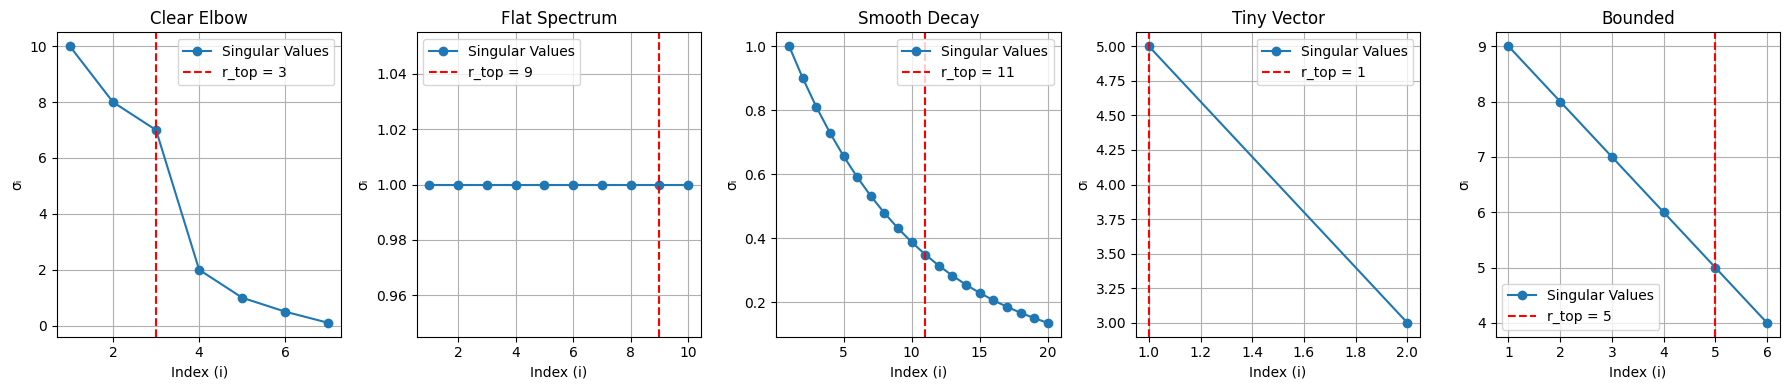

In [ ]:
import torch
import matplotlib.pyplot as plt

def choose_head_rank_by_eigen_dispersion(S: torch.Tensor,
                                         min_r: int = 1,
                                         max_r: int | None = None,
                                         energy_threshold: float = 0.90) -> int:
    S = S.detach().float().clamp_min(1e-12)
    n = S.numel()
    if n <= 2:
        return max(min_r, min(n, n - 1))
    if max_r is None:
        max_r = n - 1
    log_s = torch.log(S)
    d1 = log_s[:-1] - log_s[1:]
    d2 = d1[:-1] - d1[1:]
    k_rel = torch.argmax(d2).item()
    r_top = k_rel + 1
    if d2[k_rel] < 1e-3:
        cum = torch.cumsum(S**2, 0) ## calculation of the spectral energy as we move down the singular values
        r_top = int(torch.searchsorted(cum, energy_threshold * cum[-1]).item() + 1) #cum[-1] >> total spectral energy// energy_threshold * cum[-1] is 90% of the energy, finding the smallest r
    return max(min_r, min(r_top, max_r))

# Define test spectra
spectra = {
    "Clear Elbow": torch.tensor([10., 8., 7., 2., 1., 0.5, 0.1]),
    "Flat Spectrum": torch.ones(10),
    "Smooth Decay": torch.exp(-torch.linspace(0, 2, 20)),
    "Tiny Vector": torch.tensor([5., 3.]),
    "Bounded": torch.tensor([9., 8., 7., 6., 5., 4.])
}

# Plot each
fig, axs = plt.subplots(1, len(spectra), figsize=(18, 4))
for ax, (name, S) in zip(axs, spectra.items()):
    r_top = choose_head_rank_by_eigen_dispersion(S)
    ax.plot(range(1, len(S)+1), S, 'o-', label='Singular Values')
    ax.axvline(r_top, color='r', linestyle='--', label=f'r_top = {r_top}')
    ax.set_title(name)
    ax.set_xlabel("Index (i)")
    ax.set_ylabel("σᵢ")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [4]:
import torch
from transformers import BertModel, BertTokenizer

# Load pretrained BERT-based uncased model
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Sample text to test the model
text = "This is a test sentence for BERT."

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt")

# Forward pass through the model to get attention weights
with torch.no_grad():
    outputs = model(**inputs)

# Get the Q, K, V matrices from the first layer's attention
# We are interested in the Query (Q), Key (K), and Value (V) matrices
q_matrix = model.encoder.layer[0].attention.self.query.weight
k_matrix = model.encoder.layer[0].attention.self.key.weight
v_matrix = model.encoder.layer[0].attention.self.value.weight

# Print the dimensions of Q, K, and V matrices
print("Dimensions of the Query (Q) matrix:", q_matrix.shape)
print("Dimensions of the Key (K) matrix:", k_matrix.shape)
print("Dimensions of the Value (V) matrix:", v_matrix.shape)

# Example: Let's work with the Query matrix (Q) for the first head (index 0)
query_head = q_matrix[0]  # Select first head for simplicity

# Now, apply your function to the Query matrix (Q)
def choose_head_rank_by_eigen_dispersion(S: torch.Tensor,
                                         min_r: int = 1,
                                         max_r: int | None = None,
                                         energy_threshold: float = 0.90) -> int:
    S = S.detach().float().clamp_min(1e-12)
    n = S.numel()  
    if n <= 2:
        return max(min_r, min(n, n - 1))
    if max_r is None:
        max_r = n - 1
    log_s = torch.log(S)
    d1 = log_s[:-1] - log_s[1:]
    d2 = d1[:-1] - d1[1:]
    k_rel = torch.argmax(d2).item()
    r_top = k_rel + 1
    if d2[k_rel] < 1e-3:
        cum = torch.cumsum(S**2, 0)
        r_top = int(torch.searchsorted(cum, energy_threshold * cum[-1]).item() + 1)
    return max(min_r, min(r_top, max_r))

# Call the function with the query matrix (Q) for the first head
head_rank = choose_head_rank_by_eigen_dispersion(query_head)

print(f"Chosen head rank for the Query matrix: {head_rank}")

Dimensions of the Query (Q) matrix: torch.Size([768, 768])
Dimensions of the Key (K) matrix: torch.Size([768, 768])
Dimensions of the Value (V) matrix: torch.Size([768, 768])
Chosen head rank for the Query matrix: 382


In [2]:
print(attention_head)

tensor([0.2626, 0.0063, 0.0074, 0.0075, 0.0233, 0.2059, 0.0367, 0.0320, 0.3269,
        0.0913])
